In [10]:
# General libs for file paths, data extraction, etc
from glob import glob
from pathlib import Path
from os.path import basename
import zipfile # To extract zipfiles
import urllib3 
urllib3.disable_warnings() # Disable warnings for data download via API

# CDS API
import cdsapi

# Libraries for working with multi-dimensional arrays
import numpy as np
import xarray as xr
import pandas as pd

# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

Tutorial here https://ecmwf-projects.github.io/copernicus-training-c3s/projections-cmip6.html

# Download Datasets

In [11]:
URL = 'https://cds.climate.copernicus.eu/api/v2'
KEY = '317961:c0ffcde2-ed02-41f5-9e32-47c19445f424'

In [12]:
DATADIR = './DATASETS/'

## CMIP6 Dataset below
https://cds.climate.copernicus.eu/cdsapp#!/dataset/projections-cmip6?tab=form

experiments = ['ssp1_2_6', 'ssp2_4_5', 'ssp5_8_5']

models = ['access_cm2', 'canesm5', 'taiesm1']


### Needed Climate Parameters for Morphing Workflow:

tmax- 'daily_maximum_near_surface_air_temperature'
temp- 'near_surface_air_temperature'
tmin- 'Daily minimum near-surface air temperature'

relative humidity- 'near_surface_relative_humidity'

atmospheric pressure- 'surface_air_pressure'

wind speed- 'near_surface_wind_speed'

still need to understand radiation components:

'surface_upwelling_longwave_radiation'

'surface_upwelling_shortwave_radiation'

'surface_downwelling_shortwave_radiation'

'surface_downwelling_longwave_radiation'

In [41]:
#Example of downloading a dataset
import cdsapi

c = cdsapi.Client(url=URL, key=KEY)

c.retrieve(
    'projections-cordex-domains-single-levels',
    {
        'format': 'zip',
        'domain': 'europe',
        'experiment': 'rcp_8_5',
        'horizontal_resolution': '0_11_degree_x_0_11_degree',
        'temporal_resolution': 'monthly_mean',
        'variable': 'surface_pressure',
        'gcm_model': 'cnrm_cerfacs_cm5',
        'rcm_model': 'cnrm_aladin53',
        'ensemble_member': 'r1i1p1',
        'start_year': '2051',
        'end_year': '2060',
    },
    'download.zip')

2024-07-12 14:50:51,130 INFO Welcome to the CDS
2024-07-12 14:50:51,132 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cordex-domains-single-levels
2024-07-12 14:50:51,361 INFO Request is queued
2024-07-12 14:50:52,421 INFO Request is running
2024-07-12 14:51:41,126 INFO Request is completed
2024-07-12 14:51:41,126 INFO Downloading https://download-0000-clone.copernicus-climate.eu/cache-compute-0000/cache/data0/dataset-projections-cordex-domains-single-levels-da268047-2126-4e7b-96e2-542635030f2c.zip to download.zip (73.4M)
2024-07-12 14:51:52,306 INFO Download rate 6.6M/s                                                                      


Result(content_length=76945387,content_type=application/zip,location=https://download-0000-clone.copernicus-climate.eu/cache-compute-0000/cache/data0/dataset-projections-cordex-domains-single-levels-da268047-2126-4e7b-96e2-542635030f2c.zip)

# Set Dataset Paths (RUN ME)

In [129]:
DATADIR = './GLOBAL/'

In [52]:
DATADIR = './CORDEX-EUR11/'

In [ ]:
'''
#unzip the first time
cmip6_zip_paths = glob(f'{DATADIR}.zip')
for j in cmip6_zip_paths:
    with zipfile.ZipFile(j, 'r') as zip_ref:
        zip_ref.extractall(f'{DATADIR}')

In [136]:
import os

"""
Set up Climate parameter paths based on GCM
For now there are 2 options:
GLOBAL- global climate model GCM with low resolution
CORDEX- regional climate model RCM for the Europe region EUR11
"""
DATADIR='./CORDEX-EUR11/'
if (DATADIR=='./GLOBAL/'):
    gcm_nc_temp = glob(f'{DATADIR}tas_day_ACCESS-CM2*.nc')
    gcm_nc_tempmax = glob(f'{DATADIR}tasmax*.nc')
    gcm_nc_tempmin = glob(f'{DATADIR}tasmin*.nc')
    gcm_nc_rh = glob(f'{DATADIR}hurs_Amon_CanESM5*.nc')
    gcm_nc_wind= glob(f'{DATADIR}sfcWind_Amon_TaiESM1*.nc')
    gcm_nc_press= glob(f'{DATADIR}ps_Amon_CanESM5*.nc')
elif (DATADIR=='./CORDEX-EUR11/'):
    gcm_nc_temp = glob(f'{DATADIR}tas_*.nc')
    gcm_nc_tempmax = glob(f'{DATADIR}tasmax*.nc')
    gcm_nc_tempmin = glob(f'{DATADIR}tasmin*.nc')
    gcm_nc_rh = glob(f'{DATADIR}hurs*.nc')
    gcm_nc_wind= glob(f'{DATADIR}sfcWind*.nc')
    gcm_nc_press= glob(f'{DATADIR}ps*.nc')

In [44]:
os.path.basename(cmip6_nc_press[0])

'ps_EUR-11_CNRM-CERFACS-CNRM-CM5_rcp45_r1i1p1_CNRM-ALADIN53_v1_mon_205101-206012.nc'

In [137]:
#Datasets I will use for now
print(gcm_nc_temp)
print(gcm_nc_tempmin)
print(gcm_nc_rh)
print(gcm_nc_wind)
print(gcm_nc_press)

['./CORDEX-EUR11\\tas_EUR-11_MPI-M-MPI-ESM-LR_rcp26_r1i1p1_MPI-CSC-REMO2009_v1_day_20510101-20551231.nc', './CORDEX-EUR11\\tas_EUR-11_MPI-M-MPI-ESM-LR_rcp45_r1i1p1_MPI-CSC-REMO2009_v1_day_20510101-20551231.nc', './CORDEX-EUR11\\tas_EUR-11_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_MPI-CSC-REMO2009_v1_day_20510101-20551231.nc']
['./CORDEX-EUR11\\tasmin_EUR-11_MPI-M-MPI-ESM-LR_rcp26_r1i1p1_MPI-CSC-REMO2009_v1_day_20510101-20551231.nc', './CORDEX-EUR11\\tasmin_EUR-11_MPI-M-MPI-ESM-LR_rcp45_r1i1p1_MPI-CSC-REMO2009_v1_day_20510101-20551231.nc', './CORDEX-EUR11\\tasmin_EUR-11_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_MPI-CSC-REMO2009_v1_day_20510101-20551231.nc']
['./CORDEX-EUR11\\hurs_EUR-11_MPI-M-MPI-ESM-LR_rcp26_r1i1p1_SMHI-RCA4_v1a_mon_205101-206012.nc', './CORDEX-EUR11\\hurs_EUR-11_MPI-M-MPI-ESM-LR_rcp45_r1i1p1_SMHI-RCA4_v1a_mon_205101-206012.nc', './CORDEX-EUR11\\hurs_EUR-11_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_SMHI-RCA4_v1a_mon_205101-206012.nc']
['./CORDEX-EUR11\\sfcWind_EUR-11_MPI-M-MPI-ESM-LR_rcp26_r1i1p1_MPI-CSC

# Load and inspect Data

In [106]:
ds = xr.open_dataset(f'{DATADIR}tas_EUR-11_MPI-M-MPI-ESM-LR_rcp26_r1i1p1_MPI-CSC-REMO2009_v1_day_20510101-20551231.nc')
ds

<xarray.Dataset> Size: 1GB
Dimensions:                     (time: 1826, bnds: 2, rlat: 412, rlon: 424,
                                 vertices: 4)
Coordinates:
  * time                        (time) datetime64[ns] 15kB 2051-01-01T12:00:0...
  * rlat                        (rlat) float64 3kB -23.32 -23.21 ... 21.78 21.89
  * rlon                        (rlon) float64 3kB -28.43 -28.32 ... 17.99 18.1
    lat                         (rlat, rlon) float32 699kB ...
    lon                         (rlat, rlon) float32 699kB ...
    height                      float64 8B ...
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds                   (time, bnds) datetime64[ns] 29kB ...
    rotated_latitude_longitude  int32 4B ...
    lat_vertices                (rlat, rlon, vertices) float32 3MB ...
    lon_vertices                (rlat, rlon, vertices) float32 3MB ...
    tas                         (time, rlat, rlon) float32 1GB ...
Attributes: (12/30)
    institution:                    Helmholtz-Zentrum Geesthacht, Climate Ser...
    institute_id:                   MPI-CSC
    experiment_id:                  rcp26
    source:                         MPI-CSC-REMO2009
    model_id:                       MPI-CSC-REMO2009
    contact:                        gerics-cordex@hzg.de
    ...                             ...
    title:                          MPI-CSC-REMO2009 model output prepared fo...
    modeling_realm:                 atmos
    realization:                    1
    cmor_version:                   2.9.1
    c3s_disclaimer:                 This data has been produced in the contex...
    tracking_id:                    hdl:21.14103/c5ba893b-a9b1-4ff3-a1b0-a8cf...

In [111]:
values = ds['rlon']
values1 = ds['lon']
print(values)
print(values1)

<xarray.DataArray 'rlon' (rlon: 424)> Size: 3kB
array([-28.43, -28.32, -28.21, ...,  17.88,  17.99,  18.1 ])
Coordinates:
  * rlon     (rlon) float64 3kB -28.43 -28.32 -28.21 -28.1 ... 17.88 17.99 18.1
    height   float64 8B ...
Attributes:
    units:          degrees
    axis:           X
    long_name:      longitude in rotated pole grid
    standard_name:  grid_longitude
<xarray.DataArray 'lon' (rlat: 412, rlon: 424)> Size: 699kB
array([[-10.137466, -10.037447,  -9.937338, ...,  36.161022,  36.26873 ,
         36.37637 ],
       [-10.184687, -10.084527,  -9.984277, ...,  36.193012,  36.300896,
         36.408714],
       [-10.231975, -10.131674, -10.031282, ...,  36.22506 ,  36.33312 ,
         36.441113],
       ...,
       [-44.41804 , -44.279716, -44.14086 , ...,  64.19809 ,  64.40422 ,
         64.60944 ],
       [-44.58117 , -44.44301 , -44.30432 , ...,  64.36603 ,  64.57232 ,
         64.77769 ],
       [-44.745026, -44.60704 , -44.46853 , ...,  64.53517 ,  64.741615,
       

In [113]:
ds = xr.open_dataset(f'{DATADIR}ps_EUR-11_MPI-M-MPI-ESM-LR_rcp26_r1i1p1_UHOH-WRF361H_v1_mon_205101-206012.nc')
values = ds['ps']

selValue = values.sel(lon=epw.location.longitude, lat=epw.location.latitude, method='nearest')
selValue = selValue.sel(time='2055')
selValue.values

ValueError: cannot supply selection options {'method': 'nearest', 'tolerance': None} for dimension 'lon'that has no associated coordinate or index

In [105]:
ds = xr.open_dataset(f'{DATADIR}ps_EUR-11_CNRM-CERFACS-CNRM-CM5_rcp45_r1i1p1_CNRM-ALADIN53_v1_mon_205101-206012.nc')
values = ds['ps']

selValue = values.sel(lon=epw.location.longitude, lat=epw.location.latitude, method='nearest')
selValue = selValue.sel(time='2055')
selValue.values

KeyError: "no index found for coordinate 'lon'"

In [61]:
values

<xarray.DataArray 'tas' (time: 1826, rlat: 412, rlon: 424)> Size: 1GB
[318980288 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 15kB 2051-01-01T12:00:00 ... 2055-12-31T12...
  * rlat     (rlat) float64 3kB -23.32 -23.21 -23.1 -22.99 ... 21.67 21.78 21.89
  * rlon     (rlon) float64 3kB -28.43 -28.32 -28.21 -28.1 ... 17.88 17.99 18.1
    lat      (rlat, rlon) float32 699kB ...
    lon      (rlat, rlon) float32 699kB ...
    height   float64 8B ...
Attributes:
    standard_name:     air_temperature
    long_name:         Near-Surface Air Temperature
    comment:           daily-mean near-surface (usually, 2 meter) air tempera...
    units:             K
    cell_methods:      time: mean
    associated_files:  gridspecFile: gridspec_atmos_fx_MPI-CSC-REMO2009_rcp26...
    grid_mapping:      rotated_latitude_longitude

In [8]:
temp = ds['tas']
temp

<xarray.DataArray 'tas' (time: 36, lat: 192, lon: 288)> Size: 8MB
[1990656 values with dtype=float32]
Coordinates:
  * time     (time) object 288B 2030-01-16 12:00:00 ... 2050-12-16 12:00:00
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    height   float64 8B ...
Attributes:
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    comment:        near-surface (usually, 2 meter) air temperature
    units:          K
    original_name:  TREFHT
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        2020-11-10T09:23:26Z altered by CMOR: Treated scalar dime...

# Helper Functions (RUN ME)

In [89]:
from numpy import array
from typing import Dict, List
import warnings
import numpy as np
import pandas as pd
from pathlib import Path
from ladybug.datacollection import (
    BaseCollection,
    HourlyContinuousCollection,
    MonthlyCollection,
)
from ladybug.datatype.energyflux import (
    DiffuseHorizontalRadiation,
    DirectNormalRadiation,
    GlobalHorizontalRadiation,
)
from ladybug.datatype.fraction import OpaqueSkyCover, RelativeHumidity, TotalSkyCover
from ladybug.datatype.illuminance import (
    DiffuseHorizontalIlluminance,
    DirectNormalIlluminance,
    GlobalHorizontalIlluminance,
)
from ladybug.datatype.luminance import ZenithLuminance
from ladybug.datatype import TYPESDICT
from ladybug.datatype.generic import GenericType
from ladybug.analysisperiod import AnalysisPeriod
from ladybug.datatype.pressure import AtmosphericStationPressure
from ladybug.datatype.speed import WindSpeed
from ladybug.datatype.temperature import DryBulbTemperature
from ladybug.epw import EPW, HourlyContinuousCollection, Location, MonthlyCollection
from ladybug.psychrometrics import dew_point_from_db_rh
from ladybug.skymodel import calc_horizontal_infrared
from ladybug.header import Header
########################################################################################
from pylab import rcParams
import matplotlib
rcParams['figure.figsize'] = 15, 5
plt.style.use('ggplot')
font = {'family' : 'Arial',
        'size'   : 7}

matplotlib.rc('font', **font)

#########################################################################################
#########################################################################################
#Helper functions

def header_to_string(header: Header) -> str:
    """Convert a Ladybug header object into a string.
    Args:
        header (Header):
            A Ladybug header object.
    Returns:
        str:
            A Ladybug header string."""

    return f"{header.data_type} ({header.unit})"

def header_from_string(string: str) -> Header:
    """Convert a string into a Ladybug header object.
    Args:
        string (str):
            A Ladybug header string.
    Returns:
        Header:
            A Ladybug header object."""

    str_elements = string.split(" ")

    if (len(str_elements) < 2) or ("(" not in string) or (")" not in string):
        raise ValueError(
            "The string to be converted into a LB Header must be in the format 'variable (unit)'"
        )

    str_elements = string.split(" ")
    unit = str_elements[-1].replace("(", "").replace(")", "")
    data_type = " ".join(str_elements[:-1])

    try:
        data_type = TYPESDICT[data_type.replace(" ", "")]()
    except KeyError:
        data_type = GenericType(name=data_type, unit=unit)

    return Header(data_type=data_type, unit=unit, analysis_period=AnalysisPeriod())


def to_series(collection: BaseCollection) -> pd.Series:
    """Convert a Ladybug hourlyContinuousCollection object into a Pandas Series object.
    Args:
        collection: Ladybug data collection object.
    Returns:
        pd.Series: A Pandas Series object.
    """

    index = pd.to_datetime(collection.header.analysis_period.datetimes)
    if len(collection.values) == 12:
        index = pd.date_range(f"{index[0].year}-01-01", periods=12, freq="MS")

    return pd.Series(
        data=collection.values,
        index=index,
        name=header_to_string(collection.header),
    )

def from_series(series: pd.Series) -> BaseCollection:
    """Convert a Pandas Series object into a Ladybug BaseCollection-like object.
    Args:
        series (pd.Series): A Pandas Series object.
    Returns:
        BaseCollection: A Ladybug BaseCollection-like object.
    """

    header = header_from_string(series.name)
    header.metadata["source"] = "From custom pd.Series"

    freq = pd.infer_freq(series.index)
    if freq in ["H", "h"]:
        if series.index.is_leap_year.any():
            if len(series.index) != 8784:
                raise ValueError(
                    "The number of values in the series must be 8784 for leap years."
                )
        else:
            if len(series.index) != 8760:
                raise ValueError("The series must have 8760 rows for non-leap years.")

        return HourlyContinuousCollection(
            header=header,
            values=series.values,
        )

    if freq in ["M", "MS"]:
        if len(series.index) != 12:
            raise ValueError("The series must have 12 rows for months.")

        return MonthlyCollection(
            header=header,
            values=series.values.tolist(),
            datetimes=range(1, 13),
        )

    raise ValueError("The series must be hourly or monthly.")
    
def get_values (
    param: str,
    scenario: str,
    lon: float,
    lat: float,
    year: int,
) -> array:
    """Get monthly parameter values from closest location from the Climate Model
        selectable parameters are: temp, tempmin, tempmax, rhumidity, wind, pressure,
        selectable scenarios are: ssp126, ssp245, ssp585 """
    scn=4
    if(scenario == "sp26"):
        scn=0
    elif (scenario =="sp45"):
        scn=1
    elif (scenario =="sp85"):
        scn=2
    else:
        raise ValueError("The selected scenario is not valid")    
    
    path="notSet"
    if (param=="temp"):
        path=f'{DATADIR}{os.path.basename(gcm_nc_temp[scn])}'
        parameter="tas"
    elif (param=="tempmin"):
        path=f'{DATADIR}{os.path.basename(gcm_nc_tempmin[scn])}'
        parameter="tasmin"
    elif (param=="tempmax"):
        path=f'{DATADIR}{os.path.basename(gcm_nc_tempmax[scn])}'
        parameter="tasmax"
    elif (param=="rhumidity"):
        path=f'{DATADIR}{os.path.basename(gcm_nc_rh[scn])}'
        parameter="hurs"
    elif (param=="wind"):
        path=f'{DATADIR}{os.path.basename(gcm_nc_wind[scn])}'
        parameter="sfcWind"
    elif (param=="pressure"):
        path=f'{DATADIR}{os.path.basename(gcm_nc_press[scn])}'
        parameter="ps"
    else:
        raise ValueError("The selected parameter is not valid") 
    
    ds = xr.open_dataset(path)
    values = ds[parameter]
    
    try:
        selValue = values.sel(rlon=lon, rlat=lat, method='nearest')
    except:   
        selValue = values.sel(lon=lon, lat=lat, method='nearest')
 
    selValue = selValue.sel(time=year)
    
    if (parameter=='tas'or parameter=='tasmin' or parameter=='tasmax' ):
        return selValue.values - 273.15
    else:
        return selValue.values

def _factors_to_annual(factors: List[float]) -> List[float]:
    """Cast monthly morphing factors to annual hourly ones."""
    if len(factors) != 12:
        raise ValueError(f"This method won't work ({len(factors)} != 12).")
    year_idx = pd.date_range("2050-01-01 00:00:00", freq="60min", periods=8760)
    month_idx = pd.date_range("2050-01-01 00:00:00", freq="MS", periods=12)

    # expand values across an entire year, filling NaNs where unavailable, and bookend
    annual_values_nans = (
        pd.Series(data=factors, index=month_idx).reindex(year_idx, method=None).values
    )
    annual_values_nans[-1] = annual_values_nans[0]

    # interpolate between NaNs
    return pd.Series(annual_values_nans).interpolate().values

def _daily_to_annual(factors: List[float]) -> List[float] :
    """Cast daily morphing factors to annual hourly ones."""
    if len(factors) != 365:
        raise ValueError(f"This method won't work ({len(factors)} != 365).")
    year_idx = pd.date_range("2050-01-01 00:00:00", freq="60min", periods=8760)
    day_idx = pd.date_range("2050-01-01 00:00:00", periods=365)

    # expand values across an entire year, filling NaNs where unavailable, and bookend
    annual_values_nans = (
        pd.Series(data=factors, index=day_idx).reindex(year_idx, method=None).values
    )
    annual_values_nans[-1] = annual_values_nans[0]

    # interpolate between NaNs
    return pd.Series(annual_values_nans).interpolate().values



# Forecast Parameters (RUN ME)

In [69]:
def _forecast_dry_bulb_temperature(
    location: Location,
    dbt_collection: HourlyContinuousCollection,
    scenario: str,
    year: str
) -> HourlyContinuousCollection:
    """Forecast dry bulb temperature using downloaded datasets from CDS."""

    if not isinstance(dbt_collection.header.data_type, DryBulbTemperature):
        raise ValueError(
            f"This method can only forecast for dtype of {DryBulbTemperature}"
        )

    # test for data validity and return the original collection is all "invalid"
    if all(i == 99.9 for i in dbt_collection):
        warnings.warn(
            "The original dry bulb temperature values are all missing. The original data will be returned instead."
        )
        return dbt_collection

    # attempt to transform the input data
    index = pd.to_datetime(dbt_collection.header.analysis_period.datetimes)
    
    #values from GCM  
    tmin = _daily_to_annual(
        get_values( param = "tempmin",scenario = scenario,lon=location.longitude,lat= location.latitude, year = year)
    )
    tmin_series = pd.Series(tmin, index=index)
    temp = _daily_to_annual(
        get_values( param = "temp",scenario = scenario,lon=location.longitude,lat= location.latitude, year = year)
    )
    temp_series=  pd.Series(temp, index=index)
    tmax = _daily_to_annual(
        get_values( param = "tempmax",scenario = scenario,lon=location.longitude,lat= location.latitude, year = year)
    )
    tmax_series = pd.Series(tmax, index=index)
    dbt_new_monthly_mean = (
        temp_series.resample("1D")
        .mean()
        .resample("MS")
        .mean()
        .reindex(temp_series.index, method="ffill")
    )
    dbt_new_monthly_min = (
        tmin_series.resample("1D")
        .mean()
        .resample("MS")
        .mean()
        .reindex(tmin_series.index, method="ffill")
    )
    dbt_new_monthly_max = (
        tmax_series.resample("1D")
        .mean()
        .resample("MS")
        .mean()
        .reindex(tmax_series.index, method="ffill")
    )
    #values from epw
    series = to_series(dbt_collection)
    dbt_0_monthly_average_daily_max = (
        series.resample("1D")
        .max()
        .resample("MS")
        .mean()
        .reindex(series.index, method="ffill")
    )
    dbt_0_monthly_average_daily_mean = (
        series.resample("MS").mean().reindex(series.index, method="ffill")
    )
    dbt_0_monthly_average_daily_min = (
        series.resample("1D")
        .min()
        .resample("MS")
        .mean()
        .reindex(series.index, method="ffill")
    )
    Dtemp= dbt_new_monthly_mean-dbt_0_monthly_average_daily_mean
    Dtmax= dbt_new_monthly_max-dbt_0_monthly_average_daily_max
    Dtmin= dbt_new_monthly_min-dbt_0_monthly_average_daily_min
    
    adbt_m = (Dtmax - Dtmin) / (
        dbt_0_monthly_average_daily_max - dbt_0_monthly_average_daily_min
    )
    
    
    dbt_new = series + Dtemp + adbt_m * (series - dbt_0_monthly_average_daily_mean)
    
    plt.plot(np.array(range(0,8760 )), dbt_new.values, color="red", label="Projected Values")
    plt.plot(np.array(range(0,8760 )), series.values, color="blue", label="Original Values", alpha=0.4)
    plt.title("Projected Changes in Temperature")
    plt.legend(loc="upper right")
    plt.show()
    
    # last check to ensure results arent weird
    avg_diff_limit = 20
    if not np.allclose(series, dbt_new, atol=avg_diff_limit):
        warnings.warn(
            "Forecast for dry-bulb temperature returns values beyond feasible range of transformation. The original data will be returned instead."
        )
        return dbt_collection
    dbt_new.name=series.name
    return from_series(dbt_new)
def _forecast_relative_humidity(
    location: Location,
    rh_collection: HourlyContinuousCollection,
    scenario: str,
    year: int,
) -> HourlyContinuousCollection:
    """Forecast relative humidity using downloaded datasets from CDS."""

    if not isinstance(rh_collection.header.data_type, RelativeHumidity):
        raise ValueError(
            f"This method can only forecast for dtype of {RelativeHumidity}"
        )

    # test for data validity and return the original collection is all "invalid"
    if all(i == 999 for i in rh_collection):
        warnings.warn(
            "The original relative humidity values are all missing. The original data will be returned instead."
        )
        return rh_collection

    # attempt to transform the input data
    series = to_series(rh_collection)
    
    rh_0_monthly_average_daily_mean = (
        series.resample("MS").mean().reindex(series.index, method="ffill")
    )
    rhum = _factors_to_annual(
        get_values( param = "rhumidity",scenario = scenario,lon=location.longitude,lat= location.latitude, year = year)
    )
    rh_series = pd.Series(rhum, index=pd.to_datetime(rh_collection.header.analysis_period.datetimes))
    rh_fact = (rh_series-rh_0_monthly_average_daily_mean)/rh_0_monthly_average_daily_mean
    rh_new = (series*(1+rh_fact)).clip(0, 100)

    plt.plot(np.array(range(0,8760 )), rh_new.values, color="red", label="Projected Values")
    plt.plot(np.array(range(0,8760 )), series.values, color="blue", label="Original Values", alpha=0.4)
    plt.title("Projected Changes in Relative Humidity")
    plt.legend(loc="upper right")
    plt.show()

    
    # last check to ensure results arent weird
    avg_diff_limit = 20
    if not np.allclose(series, rh_new, atol=avg_diff_limit):
        warnings.warn(
            "Forecast for relative humidity returns values beyond feasible range of transformation. The original data will be returned instead."
        )
        return rh_collection
    rh_new.name=series.name
    return from_series(rh_new)
    
def _forecast_atmospheric_pressure(
    location: Location,
    ap_collection: HourlyContinuousCollection,
    scenario: str,
    year: int,
) -> HourlyContinuousCollection:
    """Forecast atmospheric pressure using downloaded datasets from CDS."""

    if not isinstance(ap_collection.header.data_type, AtmosphericStationPressure):
        raise ValueError(
            f"This method can only forecast for dtype of {AtmosphericStationPressure}"
        )

    # test for data validity and return the original collection is all "invalid"
    if all(i == 999999 for i in ap_collection):
        warnings.warn(
            "The original atmospheric pressure values are all missing. The original data will be returned instead."
        )
        return ap_collection

    # attempt to transform the input data
    series = to_series(ap_collection)
    ap_0_monthly_average_daily_mean = (
        series.resample("MS").mean().reindex(series.index, method="ffill")
    )
    mslp = _factors_to_annual(
        get_values( param = "pressure",scenario = scenario,lon=location.longitude,lat= location.latitude, year = year)
    )
    ap_series = pd.Series(mslp, index=pd.to_datetime(ap_collection.header.analysis_period.datetimes))
    ap_new = series + (ap_series-ap_0_monthly_average_daily_mean)
    
    plt.plot(np.array(range(0,8760 )), ap_new.values, color="red", label="Projected Values")
    plt.plot(np.array(range(0,8760 )), series.values, color="blue", label="Original Values", alpha=0.4)
    plt.title("Projected Changes in Atmospheric Pressure")
    plt.legend(loc="upper right")
    plt.show()
    
    # last check to ensure results arent weird
    avg_diff_limit = 300
    if not np.allclose(series, ap_new, atol=avg_diff_limit):
        warnings.warn(
            "Forecast for atmospheric pressure returns values beyond feasible range of transformation. The original data will be returned instead."
        )
        return ap_collection
    ap_new.name=series.name
    return from_series(ap_new)
    
def _calculate_dew_point_temperature(
    dbt_collection: HourlyContinuousCollection,
    rh_collection: HourlyContinuousCollection,
) -> HourlyContinuousCollection:
    """Calculate DPT from composite variables."""

    if all(i == 99.9 for i in dbt_collection) or all(i == 999 for i in rh_collection):
        warnings.warn(
            "The original dry bulb temperature or relative humidity values are all missing. Dew point temperature will be constructed from the default value for missing values."
        )
        return EPW.from_missing_values().dew_point_temperature

    _dbt = to_series(dbt_collection)
    _rh = to_series(rh_collection)

    dpt = []
    for dbt, rh in list(zip(*[_dbt, _rh])):
        dpt.append(dew_point_from_db_rh(dbt, rh))
    freq = pd.infer_freq(_dbt.index)
    
    
    return from_series(
        pd.Series(dpt, index=_dbt.index, name="Dew Point Temperature (C)")
    )

def _forecast_wind_speed(
    location: Location,
    ws_collection: HourlyContinuousCollection,
    scenario: str,
    year: int,
) -> HourlyContinuousCollection:
    """Forecast wind speed using downloaded datasets from CDS."""

    if not isinstance(ws_collection.header.data_type, WindSpeed):
        raise ValueError(f"This method can only forecast for dtype of {WindSpeed}")

    # test for data validity and return the original collection is all "invalid"
    if all(i == 999 for i in ws_collection):
        warnings.warn(
            "The original wind speed values are all missing. The original data will be returned instead."
        )
        return ws_collection

    # attempt to transform the input data
    series = to_series(ws_collection)
    wind = _factors_to_annual(
       get_values( param = "wind",scenario = scenario,lon=location.longitude,lat= location.latitude, year = year)
    )
    w_0_monthly_average_daily_mean = (
        series.resample("MS").mean().reindex(series.index, method="ffill")
    )
    w_series = pd.Series(wind, index=pd.to_datetime(ws_collection.header.analysis_period.datetimes))
    ws_new = (1 + (w_series-w_0_monthly_average_daily_mean)/w_0_monthly_average_daily_mean)*series
    
    plt.plot(np.array(range(0,8760 )), ws_new, color="red", label="Projected Values")
    plt.plot(np.array(range(0,8760 )), series, color="blue", label="Original Values", alpha=0.4)
    plt.title("Projected Changes in Wind Speed")
    plt.xticks(ticks=[31*24,29*24,31*24,30*24,31*24,30*24,31*24,31*24,30*24,31*24,30*24,31*24], labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
    plt.legend(loc="upper right")
    plt.show()
    
    # last check to ensure results arent weird
    avg_diff_limit = 10
    if not np.allclose(series, ws_new, atol=avg_diff_limit):
        warnings.warn(
            "Forecast for wind speed returns values beyond feasible range of transformation. The original data will be returned instead."
        )
        return ws_collection
    ws_new.name=series.name
    return from_series(ws_new)

def _modify_ground_temperature(
    original_epw: EPW, new_epw: EPW
) -> Dict[str, MonthlyCollection]:
    """Based on changes in DBT from a source and target EPW file, adjust the source monthly ground temperatures accordingly.
    Args:
        original_epw (EPW):
            The source EPW file.
        new_epw (EPW):
            The target EPW file.
    Returns:
        Dict[str, MonthlyCollection]:
            A set of Monthly ground temperature data collections.
    """
    factors = (
        to_series(new_epw.dry_bulb_temperature).resample("MS").mean()
        / to_series(original_epw.dry_bulb_temperature).resample("MS").mean()
    ).values
    new_ground_temperatures = {}
    for depth, collection in original_epw.monthly_ground_temperature.items():
        new_ground_temperatures[depth] = MonthlyCollection(
            header=collection.header,
            values=factors * collection.values,
            datetimes=collection.datetimes,
        )
    return new_ground_temperatures

In [117]:
def forecast_epw(epw: EPW, emissions_scenario: str, forecast_year: int) -> EPW:
    """Forecast an EPW using the methodology provided by Belcher et al, "Constructing design weather data for future climates"
    Args:
        epw (EPW):
            The EPW file to transform.
        emissions_scenario (str):
            An emissions scenario to forecast with.
        forecast_year (int):
            The year to forecast.
    Returns:
        EPW:
            A "forecast" EPW file.
    """


    # create an "empty" epw object eready to populate
    new_epw = EPW.from_missing_values(epw.is_leap_year)
    new_epw.location = epw.location
    new_epw.comments_1 = f"{epw.comments_1}. Forecast using transformation factors from the IPCC HadCM3 {emissions_scenario} emissions scenario for {forecast_year} according to the methodology from Jentsch M.F., James P.A.B., Bourikas L. and Bahaj A.S. (2013) Transforming existing weather data for worldwide locations to enable energy and building performance simulation under future climates, Renewable Energy, Volume 55, pp 514-524."
    new_epw.comments_2 = epw.comments_2
    new_epw._file_path = (
        Path(epw.file_path).parent
        / f"{Path(epw.file_path).stem}__CDS_{emissions_scenario}_{forecast_year}.epw"
    ).as_posix()

    # copy over variables that aren't going to change
    new_epw.years.values = epw.years.values
    new_epw.wind_direction.values = epw.wind_direction.values
    new_epw.present_weather_observation.values = epw.present_weather_observation.values
    new_epw.present_weather_codes.values = epw.present_weather_codes.values
    new_epw.aerosol_optical_depth.values = epw.aerosol_optical_depth.values
    new_epw.snow_depth.values = epw.snow_depth.values
    new_epw.days_since_last_snowfall.values = epw.days_since_last_snowfall.values
    new_epw.albedo.values = epw.albedo.values
    new_epw.liquid_precipitation_depth.values = epw.liquid_precipitation_depth.values
    new_epw.liquid_precipitation_quantity.values = (
        epw.liquid_precipitation_quantity.values
    )
    new_epw.precipitable_water.values = epw.precipitable_water.values

    # forecast variables
    new_epw.dry_bulb_temperature.values = _forecast_dry_bulb_temperature(
        epw.location, epw.dry_bulb_temperature, emissions_scenario, forecast_year
    ).values
    new_epw.relative_humidity.values = _forecast_relative_humidity(
        epw.location, epw.relative_humidity, emissions_scenario, forecast_year
    ).values
    new_epw.dew_point_temperature.values = _calculate_dew_point_temperature(
        new_epw.dry_bulb_temperature, new_epw.relative_humidity
    ).values
    new_epw.wind_speed.values = _forecast_wind_speed(
        epw.location, epw.wind_speed, emissions_scenario, forecast_year
    ).values
    try:
        new_epw.atmospheric_station_pressure.values = _forecast_atmospheric_pressure(
            epw.location,
            epw.atmospheric_station_pressure,
            emissions_scenario,
            forecast_year,
        )
    except:
        new_epw.atmospheric_station_pressure.values = epw.atmospheric_station_pressure
   

    new_epw.total_sky_cover.values = epw.total_sky_cover.values
    new_epw.opaque_sky_cover.values = epw.opaque_sky_cover.values
    new_epw.horizontal_infrared_radiation_intensity.values = epw.horizontal_infrared_radiation_intensity.values
    new_epw.global_horizontal_radiation.values = epw.global_horizontal_radiation.values
    new_epw.direct_normal_radiation.values = epw.direct_normal_radiation.values
    new_epw.diffuse_horizontal_radiation.values = epw.diffuse_horizontal_radiation.values
    new_epw.global_horizontal_illuminance.values = epw.global_horizontal_illuminance.values
    new_epw.direct_normal_illuminance.values = epw.direct_normal_illuminance.values
    new_epw.diffuse_horizontal_illuminance.values = epw.diffuse_horizontal_illuminance.values
    new_epw.zenith_luminance.values = epw.zenith_luminance.values

    # modify ground temperatures based on differences in EPW DBT
    new_epw._monthly_ground_temps = _modify_ground_temperature(epw, new_epw)

    return new_epw

# TESTING

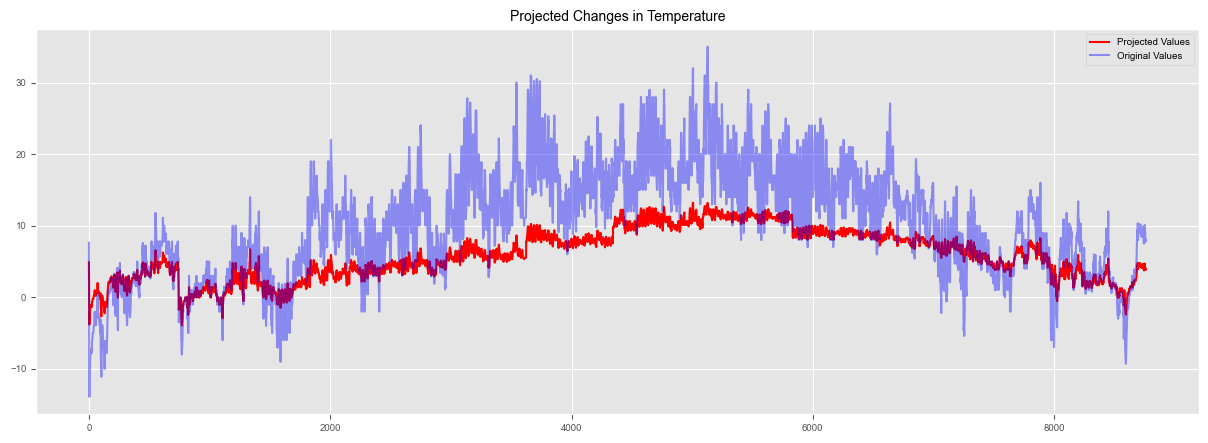

C:\Users\ebendo\AppData\Local\Temp\ipykernel_7036\598343631.py:97: UserWarning: Forecast for dry-bulb temperature returns values beyond feasible range of transformation. The original data will be returned instead.
  warnings.warn(


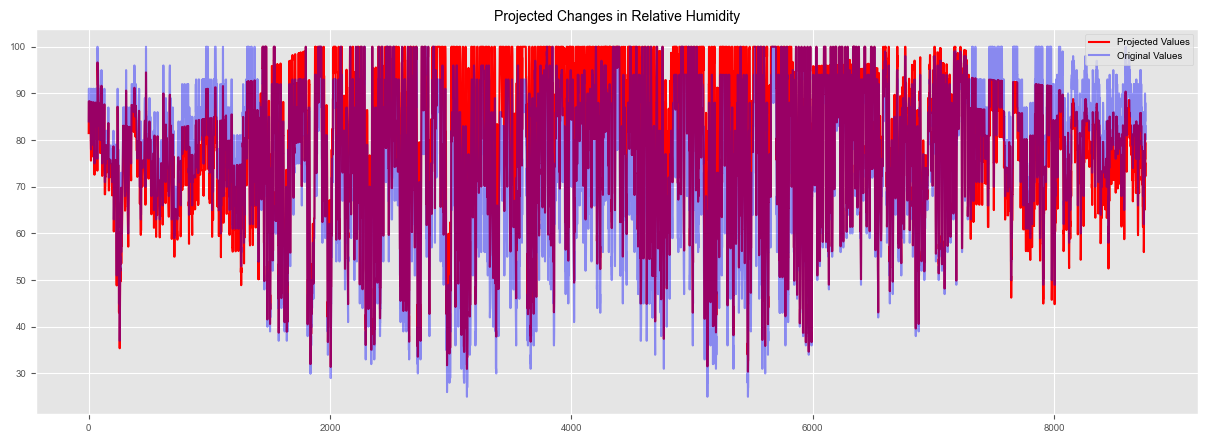

C:\Users\ebendo\AppData\Local\Temp\ipykernel_7036\598343631.py:146: UserWarning: Forecast for relative humidity returns values beyond feasible range of transformation. The original data will be returned instead.
  warnings.warn(


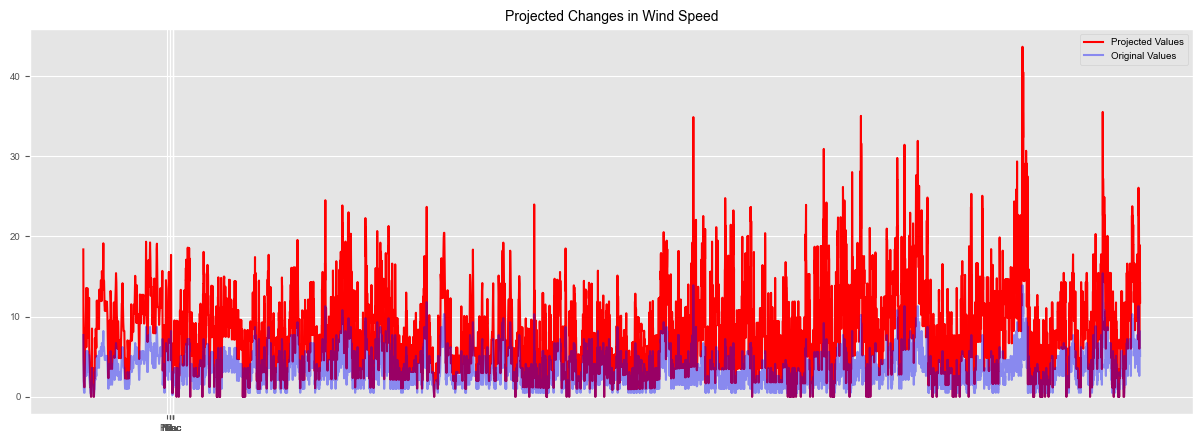

C:\Users\ebendo\AppData\Local\Temp\ipykernel_7036\598343631.py:264: UserWarning: Forecast for wind speed returns values beyond feasible range of transformation. The original data will be returned instead.
  warnings.warn(


'LOCATION,Koln.Bonn.AP,NW,DEU,SRC-TMYx,105130,50.8644,7.1575,1.0,99.5\nDESIGN CONDITIONS,0\nTYPICAL/EXTREME PERIODS,0,\nGROUND TEMPERATURES,3,0.5,,,,3.15,2.46,3.68,5.59,10.60,14.46,17.06,17.86,16.50,13.51,9.50,5.78,2.0,,,,5.68,4.45,4.71,5.72,9.07,12.10,14.52,15.82,15.54,13.84,11.08,8.15,4.0,,,,7.78,6.52,6.25,6.63,8.52,10.56,12.43,13.73,14.04,13.30,11.68,9.70\nHOLIDAYS/DAYLIGHT SAVINGS,No,0,0,0\nCOMMENTS 1,"NCEI ISD/ERA5 - #years=[65] Period of Record=1934-2021; Jan=1971; Feb=1976; Mar=2010; Apr=2006; May=1967; Jun=1982; Jul=2005; Aug=2013; Sep=1981; Oct=1983; Nov=2016; Dec=1986". Forecast using transformation factors from the IPCC HadCM3 sp85 emissions scenario for 2055 according to the methodology from Jentsch M.F., James P.A.B., Bourikas L. and Bahaj A.S. (2013) Transforming existing weather data for worldwide locations to enable energy and building performance simulation under future climates, Renewable Energy, Volume 55, pp 514-524.\nCOMMENTS 2,"Downloaded from Climate.Onebuilding.

In [140]:
epw = EPW("Koln.epw")

future_epw = forecast_epw(epw, "sp85", '2055')

future_epw.save("./FutureTest.epw")

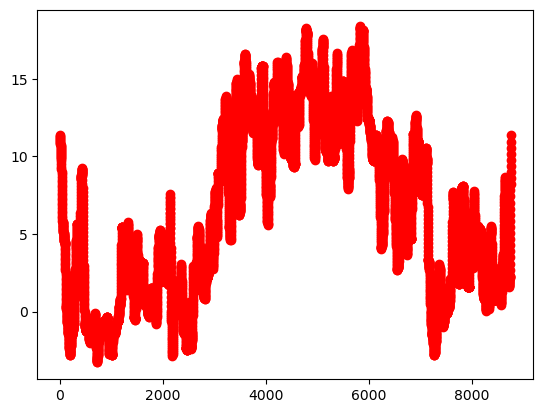

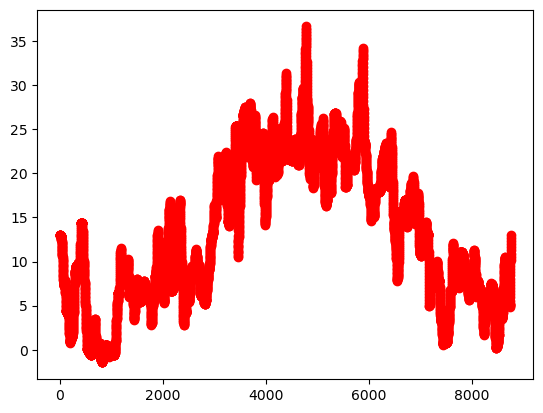

In [39]:
tempmin = get_values( param = "tempmin",
    scenario = "ssp245",
    lon=epw.location.longitude,
    lat=epw.location.latitude, year = '2050')    
tmin = _daily_to_annual(tempmin)

tempmax = get_values( param = "tempmax",
    scenario = "ssp245",
    lon=13.405454400841737,
    lat= 52.52640270246395, year = '2050')    
tmax = _daily_to_annual(tempmax)

rhum = _factors_to_annual(
        get_values( param = "rhumidity",scenario = "ssp245",lon=13.405454400841737,lat= 52.52640270246395, year = '2050')
    )

plt.plot(np.array(range(0,8760 )), tmin, color="red", marker="o", label="Array elements")
plt.show()
plt.plot(np.array(range(0,8760 )), tmax, color="red", marker="o", label="Array elements")
plt.show()

In [40]:
ds = xr.open_dataset(f'{DATADIR}{cmip6_nc_tempmin[1]}')
values = ds["tasmin"]

selValue = values.sel(lon=epw.location.longitude, lat=epw.location.latitude, method='nearest')
selValue = selValue.sel(time='2050')
selValue

<xarray.DataArray 'tasmin' (time: 365)> Size: 1kB
[365 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 3kB 2050-01-01T12:00:00 ... 2050-12-31T12:...
    lat      float64 8B 51.88
    lon      float64 8B 12.19
    height   float64 8B ...
Attributes:
    standard_name:  air_temperature
    long_name:      Daily Minimum Near-Surface Air Temperature
    comment:        minimum near-surface (usually, 2 meter) air temperature (...
    units:          K
    cell_methods:   area: mean time: minimum
    cell_measures:  area: areacella
    history:        2019-11-08T10:41:49Z altered by CMOR: Treated scalar dime...

In [29]:
len(temp)

365